In [184]:
# Please do not change this cell because some hidden tests might depend on it.
import os

# Otter grader does not handle ! commands well, so we define and use our
# own function to execute shell commands.
def shell(commands, warn=True):
    """Executes the string `commands` as a sequence of shell commands.
     
       Prints the result to stdout and returns the exit status. 
       Provides a printed warning on non-zero exit status unless `warn` 
       flag is unset.
    """
    file = os.popen(commands)
    print (file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status != None:
        print(f"Completed with errors. Exit status: {exit_status}\n")
    return exit_status

shell("""
ls requirements.txt >/dev/null 2>&1
if [ ! $? = 0 ]; then
 rm -rf .tmp
 git clone https://github.com/cs236299-2024-winter/lab2-4.git .tmp
 mv .tmp/tests ./
 mv .tmp/requirements.txt ./
 rm -rf .tmp
fi
pip install -q -r requirements.txt
""")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [185]:
# Initialize Otter
import otter
grader = otter.Notebook()

# Course 236299

## Lab 2-4 – Language models with attention

In previous labs, you have explored two different language model architectures: the _n_-gram model and Recurrent Neural Network (RNN) model. Both of these models utilize context to predict the most likely next word in a sequence, but they do so in distinct ways.

The _n_-gram model bases its predictions solely on the previous $n$ words. This method, though simple, is limited by its fixed context window. On the other hand, the RNN language model uses a hidden state that carries representations from previous time steps, theoretically enabling the model to capture long-range dependencies in text. However, in practice, RNNs often struggle with very long sequences due to issues like vanishing gradients, making them less effective for modeling extended texts.

In the upcoming lab, you will implement and explore the _attention mechanism_, a powerful technique for encoding and utilizing context from previous time steps. This will be your first step toward understanding the Transformer model, one of the most important language model innovations in recent years.

New bits of PyTorch used in the _solution set_ for this lab, and which you may therefore find useful:

* `torch.bmm`
* `torch.cumsum`
* `torch.masked_fill`
* `torch.repeat`
* `torch.softmax`
* `torch.transpose`
* `torch.triu`

# Preparation – Loading packages and data

$$
\renewcommand{\vect}[1]{\mathbf{#1}}
\renewcommand{\cnt}[1]{\sharp(#1)}
\renewcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\renewcommand{\softmax}{\operatorname{softmax}}
\renewcommand{\Prob}{\Pr}
\renewcommand{\given}{\,|\,}
$$

In [186]:
import json
import math
import random
import wget
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from math import inf
from tokenizers import Tokenizer
from transformers import PreTrainedTokenizerFast

from tqdm.auto import tqdm

In [187]:
# Set random seeds
SEED = 1234
torch.manual_seed(SEED)
random.seed(SEED)

# GPU check, sets runtime type to "GPU" where available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


We use the same data as in lab 2-3 – the *Federalist* papers.

In [188]:
# Prepare to download needed data
def download_if_needed(source, dest, filename):
    if os.path.exists(f"./{dest}{filename}"):
        print (f"Skipping {filename}")
    else: 
        print (f"Downloading {filename} from {source}")
        wget.download(source + filename, out=dest)

source_path = "https://github.com/nlp-236299/data/raw/refs/heads/master/Federalist/"
data_path = "data/"

os.makedirs(data_path, exist_ok=True)
# Download files, including pretrained language models
for filename in ["federalist_data_raw2.json",
                 "tokenizer.pt",
                 # language models:
                 # Hamilton          Madison
                 "u_attn_lm_h.pt",   "u_attn_lm_m.pt", # uniform attn
                 "attn_lm_h.pt",     "attn_lm_m.pt"    # attention
                ]:
    download_if_needed(source_path, data_path, filename)

# Read in the raw data
dataset = json.load(open(data_path + "federalist_data_raw2.json"))

# Read in the pretrained tokenizer
hf_tokenizer = torch.load(data_path + "tokenizer.pt")
hf_tokenizer.split_special_tokens = False

Skipping federalist_data_raw2.json
Skipping tokenizer.pt
Skipping u_attn_lm_h.pt
Skipping u_attn_lm_m.pt
Skipping attn_lm_h.pt
Skipping attn_lm_m.pt


Once again we will split the dataset into training, validation, and test sets. Since we have provided pretrained models, you won't be using the training set in this lab. For the validation set, we have separate ones for papers authored by Hamilton (`validation_hamilton`) and papers authored by Madison (`validation_madison`).

In [189]:
# Split training, validation, and test sets
TRAIN_RATIO = 0.9
# Extract the papers of unknown authorship
testing = list(filter(lambda ex: ex['authors'] == 'Hamilton or Madison',
                      dataset))
# Change gold labels in-place
for ex in testing:
  ex['authors'] = 'Madison'

# Extract the papers by Madison
dataset_madison = list(filter(lambda ex: ex['authors']=='Madison', dataset))
random.seed(SEED)
random.shuffle(dataset_madison)
training_size_madison = int(math.floor(TRAIN_RATIO * len(dataset_madison)))
validation_madison = dataset_madison[training_size_madison:]

# Extract the papers by Hamilton
dataset_hamilton = list(filter(lambda ex: ex['authors']=='Hamilton', dataset))
random.seed(SEED)
random.shuffle(dataset_hamilton)
training_size_hamilton = int(math.floor(TRAIN_RATIO * len(dataset_hamilton)))
validation_hamilton = dataset_hamilton[training_size_hamilton:]

# We only consider the first 200 tokens of each document for speed
def truncate(s, k=200):
  for document in s:
    document['tokens'] = document['tokens'][:k]
truncate(validation_madison)
truncate(validation_hamilton)
truncate(testing)

print (f"Madison validation size:  {len(validation_madison)} documents\n"
       f"Hamilton validation size: {len(validation_hamilton)} documents")

Madison validation size:  3 documents
Hamilton validation size: 6 documents


Before diving into the *attention mechanism*, we’d like to offer some intuitions about its underlying idea. You’ll begin by exploring simple models that will help you understand the basic concepts behind it.

# A uniform attention model

Recall the forward step in RNN models, starting with converting words to an embedding:

$$
\vect{x}_t = \vect{U}{\vect{w}_t} \\
$$

followed by the RNN layer proper (note that the non-linearity is ommited):

$$
\vect{h}_t = \vect{W}\vect{h}_{t-1} + \vect{V}\vect{x}_i\\
$$

and finally, a linear layer and softmax to convert to a distribution over the vocabulary.

$$
\vect{y}_t = \textrm{softmax}(\vect{X}\vect{h}_t)
$$

Here, 

* $\vect{w}_t$ is the word (one-hot or vocabulary index) at time step $t$,
* $\vect{x}_t$ is the corresponding embedding of size $D$,
* $\vect{h}_t$ is the hidden value encapsulating the history of size $H$, and
* $\vect{y}_t$ is the output.

The parameters of the model are the matrices $\vect{U}, \vect{V}, \vect{W}, \vect{X}, \vect{Q}, \vect{K}, \vect{V}$.

Notice how $\vect{h}_t$ has access to representations from previous time steps only through $\vect{h}_{t-1}$. In addition, calculating $\vect{h}_t$ requires waiting for the computation of $\vect{h}_{t-1}$; for this reason, RNNs are inherently serial in their computations. You will now test a new approach where the context at time step $t$ directly incorporates word embeddings from all previous time steps.

You will first explore a simple and naive model called *The Uniform Attention Model*, so-called because at each time step the model assigns equal attention to all previous words when calculating the distribution for the next word.

At each time step $t$, $\vect{h}_t$ is calculated simply based on the sum of all the previous word embeddings $\vect{x}_1,\vect{x}_2, \ldots \vect{x}_{t}$ as above except that

$$
\vect{h}_t = \sum_{i=1}^{t}{\vect{x}_i}
$$

Now, complete the implementation of the `forward` function. (As usual, the final softmax is handled by the loss function, so you needn't handle that.)

> **Hint:** You might find [`torch.cumsum`](https://pytorch.org/docs/stable/generated/torch.cumsum.html) helpful.

<!--
BEGIN QUESTION
name: uattnlm_forward
-->

In [190]:
class UATTNLM(torch.nn.Module):
  def __init__(self, hf_tokenizer, embedding_size, hidden_size):
    super().__init__()
    self.hf_tokenizer = hf_tokenizer
    self.pad_index = hf_tokenizer.pad_token_id
    self.hidden_size = hidden_size
    vocab_size = len(hf_tokenizer)

    # In this uniform attention model, the hidden size and the 
    # embedding size must be the same, since the former is 
    # just a sum over the latter
    assert hidden_size == embedding_size
    
    # Create modules
    self.embed = torch.nn.Embedding(vocab_size, embedding_size)
    self.hidden2output = torch.nn.Linear(hidden_size, vocab_size)

  def forward(self, context_words):
    """Computes the distribution over the next word given 
       context `history_words`.
       
    Arguments:
      context_words: a list of word strings, could be an 
                     empty list when generating the first word.
    Returns:
      logits, should be a tensor of size (bsz, seq_len, vocab_size)
      """
    self.eval()
    context = self.hf_tokenizer(context_words, is_split_into_words=True, return_tensors='pt')['input_ids']\
              .long()\
              .to(device) # bsz, context_len
    context_len = context.size(1)

    # For generating the first word, we feed in a special beginning-of-sentence symbol <pad>,
    # which is also what we use for padding. In future labs we'll be using <bos>, but as long
    # as training and evaluation use the same beginning-of-sentence symbol, it doesn't matter
    # which particular symbol we use.
    if context_len == 0:
      context = context.new(1, 1).fill_(self.pad_index)
      context_len = context.size(1)

    hidden = None
    # TODO: calculate output and set logits
    # Logits should be a tensor of size (1, seq_len, vocab_size)
    # The structure of the network is
    #   embeddings -> output -> hidden2output -> logits
    embeddings = self.embed(context)
    hidden = torch.cumsum(embeddings, dim=1)
    logits = self.hidden2output(hidden)
    return logits

<!--
BEGIN QUESTION
name: uattnlm_forward
-->
**Question:** For uniform attention to work as above, $H$ and $D$, the hidden size and the embedding size, must be the same. Why?

In this model, the hidden layer at each time step $t$, $\vect{h}_t$ is calculated simply based on the sum of all the previous word embeddings $\vect{x}_1,\vect{x}_2, \ldots \vect{x}_{t}$. The sum of vectors must be the same shape as the vetors themselves.

Now, let's load the models for Hamilton and Madison. The model `u_attn_lm_madison` was trained on documents authored by Madison, while `u_attn_lm_hamilton` was trained on documents authored by Hamilton.

In [191]:
# Create and load uniform attention LM for Madison
u_attn_lm_madison = UATTNLM(hf_tokenizer,
                            embedding_size=128,
                            hidden_size=128,
                           ).to(device)
u_attn_lm_madison.load_state_dict(
    torch.load(data_path + 'u_attn_lm_m.pt',
               map_location=device))

# Create and load uniform attention LM for Hamilton
u_attn_lm_hamilton = UATTNLM(hf_tokenizer,
                             embedding_size=128,
                             hidden_size=128,
                            ).to(device)
u_attn_lm_hamilton.load_state_dict(
    torch.load(data_path + 'u_attn_lm_h.pt',
               map_location=device))

<All keys matched successfully>

Let's try to sample from the model. Don’t expect a fluent text yet—more improvements are needed in the model.

In [192]:
def sample(model, context):
    """Returns a token sampled from the `model` assuming the `context`"""
    logits = model(context)[:,-1] # calls internally to model.forward(context)

     # Normalize to get probabilities
    probs = torch.softmax(logits, -1).view(-1) # vocab_size

    # Match probabilities with actual word types
    distribution = {}
    for i, prob in enumerate(probs):
      word = model.hf_tokenizer.decode(i, clean_up_tokenization_spaces=True)
      distribution[word] = prob.item()

    prob_remaining = random.random()
    for token, prob in sorted(distribution.items()):
        if prob_remaining < prob:
            return token
        else:
            prob_remaining -= prob
    raise ValueError

def sample_sequence(model, start_context, count=100):
    """Returns a sequence of tokens of length `count` sampled successively
       from the `model` starting with the `start_context`
    """
    random.seed(SEED) # for reproducibility
    context = list(start_context)
    result = list(start_context)
    for i in range(0, count):
        next = sample(model, tuple(context))
        result.append(next)
        context = context + [next]
    return result

In [193]:
print(' '.join(sample_sequence(u_attn_lm_madison,
                               ('constitution', 'proposed', 'by', 'the'))), "\n")
print(' '.join(sample_sequence(u_attn_lm_hamilton,
                               ('constitution', 'proposed', 'by', 'the'))))

constitution proposed by the virtuous hope . those unwise notorious population an revenue convention , the had of on and be [UNK] , of which . the subject the ? the government one the of is as to of the , the , [UNK] of of , the all the [UNK] they the to [UNK] federal , are the [UNK] [UNK] to [UNK] the , of in of the of the of the the of the the convention . [UNK] of . the the of the states people and states the , the [UNK] , states of states [UNK] , [UNK] , , , 

constitution proposed by the violated here [UNK] thing union misrepresentations peculiarly america restraint consist [UNK] secure expenses observed now but command arise , into when affairs man in objection a naturally debts mislead our in disciplining being us if language , itself , a in extent , of [UNK] more [UNK] understood the we . a , a the [UNK] , when [UNK] to , and a [UNK] the and the by the the of on the and [UNK] [UNK] of [UNK] of the of the of of [UNK] the the [UNK] the [UNK] [UNK] of of the [UNK] , [UNK] , [UNK] 

In [194]:
grader.check("uattnlm_sample")

All tests passed!

In the previous model, we made a simple assumption – that all previous words are equally important. Of course, this simple assumption is wrong in general, as different time steps can have varying levels of importance and dependencies.

Next, you will build a model that differentiates between time steps.

Are you ready? You’re about to learn about one of the most important mechanisms invented in recent years.

# The attention mechanism

The previous model was quite basic and suffered from an obvious problem:

At each time step, we assumed the dependencies on the previous time steps, the context, were static. Ideally, we want the model to determine dynamically at each stage which parts of the context are more relevant and which are less, that is, which parts of the context to _attend to_.

You'll now be introduced to the _attention mechanism_ (proposed in [this seminal paper](https://arxiv.org/abs/1409.0473)), a powerful architecture that allows models to selectively focus on different parts of the input sequence. This mechanism has become a cornerstone in modern natural-language processing, significantly enhancing a model's ability to model language distributions.

Attention works by _querying_ a (dynamically sized) sequence of _keys_ associated with _values_. Each key-value pair is associated with the context elements of a particular token.

As usual, each query, key, and value is represented as a vector. Attention proceeds as follows: The query is compared to each of the keys, providing a score that specifies how much each key should be attended to. The attention can then be summarized by taking an average of the _values_ weighted by the attention score of the corresponding _keys_. This _context vector_ can then be used as another input to other processes you will learn about in the next lab.

More formally, let's suppose we have a query vector $\vect{q}$ of size $D$, a set of $S$ keys $\vect{k}_i$ each of size $D$ and a set of $S$ values $\vect{v}_i$ each of size $D$, where $D$ is the embedding size. What we want to do through the attention mechanism is to use the query to attend to the keys, and summarize those values associated with the "relevant" keys into a fixed-size context vector $\vect{c}_i$ also of size $D$. Note that this is different from directly compressing the key-value pairs into a fixed-size vector, since depending on the query, we might end up with different context vectors.

> In general, not all of these need to be of the same size $D$, but we restrict to that case here for simplicity.

We'll turn to implementing this attention mechanism shortly, but first, for concreteness, we show how the mechanism can be used to form a language model. Like the uniform attention mechanism above, we start with an embedding of the vocabulary.

$$
\vect{x}_t = \vect{U}{\vect{w}_t}
$$

Next, we construct a query, key, and value for each position with linear transforms for each:

$$
\begin{aligned}
\vect{q}_t &= \vect{Q}{\vect{w}_t} \\
\vect{k}_t &= \vect{K}{\vect{w}_t} \\
\vect{v}_t &= \vect{V}{\vect{w}_t}
\end{aligned}
$$

followed by the attention layer proper:

$$
\vect{h}_t = \operatorname{attn}(\vect{q}_t, \vect{k}_{1:t}, \vect{v}_{1:t})
$$

and finally, a linear layer and softmax to convert to a distribution over the vocabulary.

$$
\vect{y}_t = \textrm{softmax}(\vect{X}\vect{h}_t)
$$

> We write $\vect{k}_{1:t}$ for the sequence of elements $\langle\vect{k}_1, \vect{k}_2, \ldots, \vect{k}_t\rangle$.

Now back to how the attention calculation works.

To determine the score for a given query and key, it is standard to use a measure of similarity between the query and key. You've seen such similarity measures before, in labs 1-1 and 1-2. A good choice is simply the normalized dot product between query and key. We'll thus take the attention score for query $\vect{q}$ and key $\vect{k}_i$ to be

$$
s_i = \frac{\vect{q} \cdot \vect{k}_i}{\sqrt{D}}
$$

and the attention vector to be the softmax of the score

$$
\vect{a} = \operatorname{softmax}(\vect{s})
$$

where $\cdot$ denotes the dot product (inner product). (There are multiple ways of parameterizing the attention function, but the form we present here is the most popular one.).

The softmax guarantees that the attention scores $\vect{a}$ lie on a *simplex* (meaning $a_i\ge 0$ and $\sum_i a_i=1$), so $\vect{a}$ can be viewed as a probability distribution over the key-value pairs. This also lends it some interpretability: the closer $a_i$ is to 1, the more "relevant" a key $k_i$ (and hence its value $v_i$) is to the given query.

> Why divide through by the square root of the hidden size (the length of $\vect{q}$ and of $\vect{k}$)? This bit of neural network magic is one of many in the black art of machine learning. Without this scaling, the dot product values can get quite large, leading to numerical problems in perfroming the softmax.

Finally, to compute the result of the attention query – the "context vector" $\vect{c}$ – we take the weighted sum of values using the corresponding attention scores as weights:

$$
\vect{c} = \sum_{i=1}^S a_i \vect{v}_i
$$

The closer $a_i$ is to 1, the higher the weight $\vect{v}_i$ receives, and the more the context vector "attends to" the value $\vect{v}_i$ at position $i$.

> In usage, the result of attention, the context vector for position $t$, plays the role of $\vect{h}_t$, as above.

<!--
BEGIN QUESTION
name: open_response_a_i_1
-->

**Question:** Suppose there exists $i$ for which $a_i$ is 1. What will the value of $\vect{c}$ be?

The value of $\vect{c}$ will be the value of $\vect{v}_i$

In practice, instead of computing the context vector once for each query, we want to combine together computations for different queries (for different positions $t$ in the input) to allow for parallel processing on GPUs. This will become especially useful for the transformer implementation in the next lab. We use a matrix $Q\in\mathbb{R}^{{T} \times D}$ to store $T$ queries, a matrix $K\in\mathbb{R}^{S \times D}$ to store $S$ keys, and a matrix $V\in\mathbb{R}^{S\times D}$ to store the corresponding values. Then we can write down how we compute the attention scores $A\in\mathbb{R}^{T \times S}$ in a matrix form:

$$
A = \operatorname{softmax} (Q K^{\top}, \text{dim}=-1)
$$

and to get the context matrix $C \in \mathbb{R}^{T \times D}$, we have

$$
C = A V
$$

<!--
BEGIN QUESTION
name: open_response_a_ij_meaning
-->
**Question:** What is the shape of $A$? What does $A_{ij}$ represent?

The shape of $A$ is $T\times S$. $A_{ij}$ represents the attention score of the jth key-value pair in the ith query

Your first job is to implement this calculation by finishing the attention function below, which takes the $Q$, $K$, and $V$ matrices and returns the $A$ and $C$ matrices. Note that for these matrices, there is one additional dimension for the batching, so instead of $Q\in \mathbb{R}^{T \times D}$, $K,V\in \mathbb{R}^{S \times D}$, $A\in \mathbb{R}^{T \times S}$, $C\in \mathbb{R}^{T \times D}$, we have $Q\in\mathbb{R}^{B \times T \times D}$, $K,V\in \mathbb{R}^{B \times S\times D}$, $A\in \mathbb{R}^{B\times T \times S}$, $C\in \mathbb{R}^{B \times T \times D}$, where $B$ is the batch size.  In addition, the function below also takes an argument `mask` of size $\mathbb{R}^{B\times T \times S}$ to mark where attentions are disallowed. This is useful not only in disallowing attending to padding symbols, but also to efficiently train the model.

> **Hint:** You might find [`torch.bmm`](https://pytorch.org/docs/stable/generated/torch.bmm.html) helpful for batched matrix multiplications. You might need to transpose and reshape tensors to be able to use this function.

> **Hint:** As mentioned in the beginning of the lab, you might also find [`torch.transpose`](https://pytorch.org/docs/stable/generated/torch.transpose.html), [`torch.reshape`](https://pytorch.org/docs/stable/generated/torch.reshape.html), [`torch.masked_fill`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.masked_fill), and [`torch.softmax`](https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#softmax) useful.

> **Hint:** A simple trick for masking an attention score is to set it to negative infinity before normalization.

> **Hint:** Debugging the `attention` function can be tricky. Try defining a very small example of batched $\vect{q}$, $\vect{k}$, and $\vect{v}$ values for which you can manually carry out the attention claculation and test the code on those, working your way up to more complex examples.

<!--
BEGIN QUESTION
name: attention
-->

In [195]:
#TODO - finish implementing this function.
def attention(batched_Q, batched_K, batched_V, mask=None):
  """
  Performs the attention operation and returns the attention matrix
  `batched_A` and the context matrix `batched_C` using queries
  `batched_Q`, keys `batched_K`, and values `batched_V`.

  Arguments:
      batched_Q: (bsz, q_len, D)
      batched_K: (bsz, k_len, D)
      batched_V: (bsz, k_len, D)
      mask: (bsz, q_len, k_len). An optional boolean mask *disallowing*
            attentions where the mask value is *`False`*.
  Returns:
      batched_A: the normalized attention scores (bsz, q_len, k_len)
      batched_C: a tensor of size (bsz, q_len, D).
  """
 # Check sizes
  D = batched_Q.size(-1)
  bsz = batched_Q.size(0)
  q_len = batched_Q.size(1)
  k_len = batched_K.size(1)
    
  assert batched_K.size(-1) == D and batched_V.size(-1) == D
  assert batched_K.size(0) == bsz and batched_V.size(0) == bsz
  assert batched_V.size(1) == k_len
  if mask is not None:
    assert mask.size() == torch.Size([bsz, q_len, k_len]), f"{mask.size()} {torch.Size([bsz, q_len, k_len])}"

  ...
  res = (1 / math.sqrt(D)) * torch.bmm(batched_Q, batched_K.transpose(1, 2))
  if mask is not None:
    res = res - torch.where(mask, math.inf, 0)
  batched_A = torch.softmax(res, dim=-1)
  batched_C = torch.bmm(batched_A, batched_V)
  # Verify that things sum up to one properly.
  assert torch.all(torch.isclose(batched_A.sum(-1),
                                 torch.ones(bsz, q_len).to(device)))
  return batched_A, batched_C

## Causal attention mask

To efficiently train the model, we want to batch the attention operations together such that they can be fully parallelized along the sequence length dimension. (The non-attention operations are position-wise so they are trivally parallelizable.) Each word at position $t$ attends to itself and the $t-1$ previous words $1, \ldots, {t-1}$, which means each word has access to a different set of key-value pairs. It might seem then that we can't compute attention for all of the positions at the same time. Is it possible to batch them together?

The solution is to use *attention masks*. For every position $t$, we give it _all_ key-value pairs at positions $1, \ldots, T$, and we disallow attending to future words ${t+1}, {t+2},\ldots, T$ through an attention mask. (Recall that the `attention` function takes a `mask` argument.) We usually call this attention mask a _causal attention mask_, as it prevents the leakage of information from the future into the present. Since every $t$ has the same set of (key, value) pairs, we can batch them and compute the context vectors using a single call to the function `attention`.

What should such a mask be? Implement the `causal_mask` function below to generate this mask.

> Hint: you might find [`torch.triu`](https://pytorch.org/docs/stable/generated/torch.triu.html) useful.

<!--
BEGIN QUESTION
name: causal_attention_mask
-->

In [196]:
#TODO - implement this function, which returns a causal attention mask
def causal_mask(T):
  """
  Generate a causal mask.
  Arguments:
      T: the length of target sequence
  Returns:
      mask: a T x T tensor, where `mask[i, j]` should be `True`
      if position i can attend to position j, and `False` if i cannot
      attend to j
  """
  mask = torch.triu(torch.ones(T, T, dtype=torch.bool), diagonal=1)
  return mask.to(device)

In [197]:
grader.check("causal_attention_mask")

All tests passed!

We can visualize the attention mask and manually check if it's what we expected.

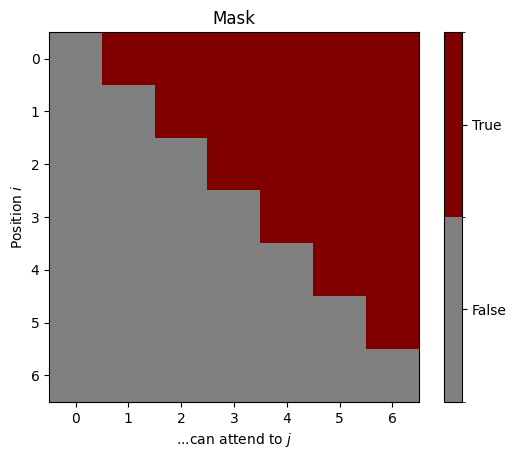

In [198]:

T = 7
mask = causal_mask(T)

# Create a colormap where True is one color and False is another
cmap = mcolors.ListedColormap(['gray', 'maroon'])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the matrix
plt.imshow(mask, cmap=cmap, norm=norm)

# Add colorbar with labels
cbar = plt.colorbar(ticks=[0, 1])
cbar.ax.set_yticklabels(['False', 'True'])  # Customize your labels here

# Label the axes
plt.ylabel('Position $i$')
plt.xlabel('...can attend to $j$')
plt.title('Mask');

# Uncomment the line below if the plot does not show up
# Make sure to comment that before submitting to gradescope
# since there would be some autograder issues with `plt.show()`
#plt.show()

By using causal masks, all positions (at the same layer) can be computed at once (if the lower layer has been computed). The parallelizability of the attention mechanism is the key to its success since it allows for training  on vast amounts of data.

Now we are ready to complete the attention model.
> Hint: The causal mask is a 2-D matrix, but we want to add a batch dimension, and expand it to be of the desired size. For this purpose, you can use [`torch.repeat`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.repeat) or [torch.expand](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html).

Complete the `forward` function.

<!--
BEGIN QUESTION
name: attnlm_forward
-->

In [199]:
class ATTNLM(torch.nn.Module):
  def __init__(self, hf_tokenizer, embedding_size, hidden_size):
    super().__init__()
    self.hf_tokenizer = hf_tokenizer
    self.pad_index = hf_tokenizer.pad_token_id
    self.hidden_size = hidden_size
    vocab_size = len(hf_tokenizer)

    # Create modules
    self.embed = torch.nn.Embedding(vocab_size, embedding_size)
    self.q_proj = nn.Linear(hidden_size, hidden_size)
    self.k_proj = nn.Linear(hidden_size, hidden_size)
    self.v_proj = nn.Linear(hidden_size, hidden_size)
    self.hidden2output = torch.nn.Linear(hidden_size, vocab_size)

  def forward(self, context_words):
    """Computes the distribution over the next word given context `history_words`.
    Arguments:
      context_words: batch a list of word strings, could be an empty list when generating
                     the first word.
    Returns:
      logits, should be a tensor of size (batch , seq_length , vocab_size)
      """
    self.eval()
    context = self.hf_tokenizer(context_words, is_split_into_words=True, return_tensors='pt')['input_ids']\
              .long()\
              .to(device) # bsz, context_len
    context_len = context.size(1)
    context_bsz = context.size(0)

    # For generating the first word, we feed in a special beginning-of-sentence symbol <pad>,
    # which is also what we use for padding. In future labs we'll be using <bos>, but as long
    # as training and evaluation use the same beginning-of-sentence symbol, it doesn't matter
    # which particular symbol we use.
    if context_len == 0:
      context = context.new(1, 1).fill_(self.pad_index)
      context_len = context.size(1)

    hidden = None
    # TODO: finish feedforward and set logits
    # Logits should be a tensor of size (bsz, seq_length, vocab_size)
    # The structure of the network is
    #   embeddings -> output -> hidden2output -> logits
    embeddings = self.embed(context)
    q = self.q_proj(embeddings)
    k = self.k_proj(embeddings)
    v = self.v_proj(embeddings)
    mask = causal_mask(context_len)
    mask = mask.expand(context_bsz, -1, -1)
    output = attention(q, k, v, mask)[1]
    logits = self.hidden2output(output)
    return logits



Now, let's load the pretrained models for Hamilton and Madison. The model `attn_lm_madison` was trained on documents authored by Madison, whereas `attn_lm_hamilton` was trained on documents authored by Hamilton.

In [200]:
# Create and load attention LM for Madison
attn_lm_madison = ATTNLM(hf_tokenizer,
                         embedding_size=128,
                         hidden_size=128,
                        ).to(device)
attn_lm_madison.load_state_dict(torch.load(data_path + 'attn_lm_m.pt', map_location=device))

# Create and load attention LM for Hamilton
attn_lm_hamilton = ATTNLM(hf_tokenizer,
                          embedding_size=128,
                          hidden_size=128,
                         ).to(device)
attn_lm_hamilton.load_state_dict(torch.load(data_path + 'attn_lm_h.pt', map_location=device))

<All keys matched successfully>

In [201]:
grader.check("attnlm_sample")

All tests passed!

In [202]:
grader.check("attnlm_sample")

All tests passed!

## Sampling from the attention model

Let's try to sample from the models.

In [203]:
print(' '.join(sample_sequence(attn_lm_madison, ('constitution', 'proposed', 'by', 'the'))), "\n")
print(' '.join(sample_sequence(attn_lm_hamilton, ('constitution', 'proposed', 'by', 'the'))))

constitution proposed by the united executive , we will far should as the effect , the government must find and an apportionment . not very [UNK] internal its number ? should be instead of state [UNK] alleged to half is , men , and in permit a mistake a measure necessarily were so universal act by a domestic security . be unwise an see [UNK] by order forms to in the legislative properly states by the senate . are and have appointed itself then hand to send on our power of but to be blended their present republics and [UNK] by a easily . 

constitution proposed by the united states , whatever we may held , the either , their first mode of an alteration , , in us , it is may are left as more necessary of making armies will become the [UNK] in [UNK] . the habitual [UNK] laid 1 not adversaries was so unnecessary . that [UNK] and the constitution , will be secured , if it has raised in the influence that to happen they sometimes choose a constant for alliance intrusted to i safely occasions

## Evaluating text according to the attention model

In [204]:
document_madison = validation_madison[0]['tokens']
document_hamilton = validation_hamilton[0]['tokens']

Just like in Lab 2-3, we want to evaluate the models using perplexity.

In [205]:
def neglogprob(tokens, model):
    """Returns the negative log probability of a sequence of `tokens`
       according to a `model`
    """
    score = 0.0
    for i in range(len(tokens)):
      context = tokens[:i]
      token = tokens[i]
      distribution = model(context)
      logits = model(context)[:,-1]
      probs = torch.softmax(logits, -1).view(-1) # vocab_size
      distribution = {}
      for i, prob in enumerate(probs):
        word = hf_tokenizer.decode(i, clean_up_tokenization_spaces=True)
        distribution[word] = prob.item()
      prob = distribution[token] if token in distribution else distribution['[UNK]']
      score += -math.log2(prob)
    return score

In [206]:
def perplexity(tokens, model):
    """Returns the perplexity of a sequence of `tokens` according to a `model`
    """
    return 2 ** (neglogprob(tokens, model) / (len(tokens)))

Calculate the perplexity of each model on each document.

<!--
BEGIN QUESTION
name: rnn_ppl
-->

In [207]:
# TODO
attn_ppl_madison_model_madison_document = perplexity(document_madison, attn_lm_madison)
attn_ppl_hamilton_model_madison_document = perplexity(document_madison, attn_lm_hamilton)
attn_ppl_madison_model_hamilton_document = perplexity(document_hamilton, attn_lm_madison)
attn_ppl_hamilton_model_hamilton_document = perplexity(document_hamilton, attn_lm_hamilton)

Now, let's compare those perplexity values. Do the results make sense to you?


In [208]:
print (f"Author      Madison Model        Hamilton Model\n"
       f"Madison        {attn_ppl_madison_model_madison_document:5.1f}                {attn_ppl_hamilton_model_madison_document:5.1f}\n"
       f"Hamilton       {attn_ppl_madison_model_hamilton_document:5.1f}                {attn_ppl_hamilton_model_hamilton_document:5.1f}")

Author      Madison Model        Hamilton Model
Madison        168.1                232.2
Hamilton       268.4                154.0


In [209]:
grader.check("perplexities")

All tests passed!

Although attention is a useful concept, it alone isn't enough to build a strong model. In the next lab, you will learn about the *Transformer language model*, which is built on the attention mechanism along with several other important components.

# Lab debrief

**Question:** We're interested in any thoughts your group has about this lab so that we can improve this lab for later years, and to inform later labs for this year. Please list any issues that arose or comments you have to improve the lab. Useful things to comment on include the following:

* Was the lab too long or too short?
* Were the readings appropriate for the lab?
* Was it clear (at least after you completed the lab) what the points of the exercises were?
* Are there additions or changes you think would make the lab better?

<!--
BEGIN QUESTION
name: open_response_debrief
manual: true
-->

_Type your answer here, replacing this text._

# End of Lab 2-4 {-}

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [210]:
grader.check_all()

attnlm_sample:

    All tests passed!
    

causal_attention_mask:

    All tests passed!
    

perplexities:

    All tests passed!
    

uattnlm_sample:

    All tests passed!